
# PINN (Physics Informed Neural Network)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from IPython import display

## Define $\omega$ and $\delta$ and plot analytic solution

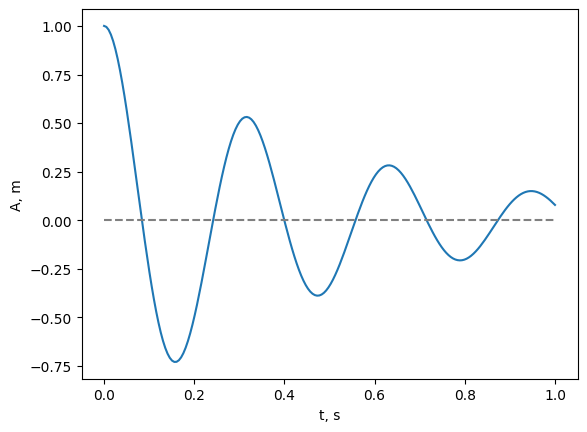

In [10]:
def anal(d,w0,t):
    assert d < w0, 'not an underdamped case!'
    #print(d,w0,t )
    d,w0, = torch.tensor(d),torch.tensor(w0)
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    C = 1/torch.cos(phi)
    sol = C * torch.exp(-d*t) * torch.cos(w*t + phi) 
    return sol.clone().detach().squeeze().cpu()

d = 2; w0 = 20
ts = torch.linspace(0,1,200)
us = anal(d,w0,ts)
plt.plot(ts,us)
plt.hlines(0, 0,1, ls='--', colors='gray')
plt.xlabel('t, s')
plt.ylabel('A, m');

## Strategy
Minor changes from previous code in PINN_01. removed boundary conditions, instead fit to observed data is enforced.

Additional parameter is added into optimization- $\mu$ for $\ddt{u}$ term
***
Solution will be guided by enforcing:

1. difference with observed data:

$$ Loss_1 = MSE[u_{obs}(t_i) - u_{model}(t_i)]$$

2. by minimizing residual (similarly to how its done in numerical models). i.e for all/any test time $t=t_i \in [0,1]$, governing differential equation should be satisfied:

    given that $u(t)$ is a true solution and $u^*(t)$ is an intermediate solution, we should minimize

    $$Loss_2 =\| \mathcal{L}u^* - \mathcal{L}u \| = \|\mathcal{L}u^* - 0\| = \|\mathcal{L}u^*\|$$

    In our case for samples at different times $Loss_2 =MSE(\mathcal{L}[u^*])=\frac{1}{N}\sum_{i}^{N} (\mathcal{L}[u^*(t_i)])^2$



## Define a model

In [11]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUPUT, N_HIDDEN, N_LAYERS) -> None:
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
           nn.Linear(N_INPUT,N_HIDDEN),
           activation()
        )
        self.fch = nn.Sequential(
            *[nn.Linear(N_HIDDEN,N_HIDDEN),activation()]*(N_LAYERS-1)
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUPUT)

    def forward(self,x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    
torch.manual_seed(69)
pinn = FCN(1,1,32,3).to(device)
test_inp = torch.tensor(0.).view(-1,1)
test_inp.size
summary(pinn, (1,1,1));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 32]            --
|    └─Linear: 2-1                       [-1, 1, 1, 32]            64
|    └─Tanh: 2-2                         [-1, 1, 1, 32]            --
├─Sequential: 1-2                        [-1, 1, 1, 32]            --
|    └─Linear: 2-3                       [-1, 1, 1, 32]            1,056
|    └─Tanh: 2-4                         [-1, 1, 1, 32]            --
|    └─Linear: 2-5                       [-1, 1, 1, 32]            (recursive)
|    └─Tanh: 2-6                         [-1, 1, 1, 32]            --
├─Linear: 1-3                            [-1, 1, 1, 1]             33
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


## Train

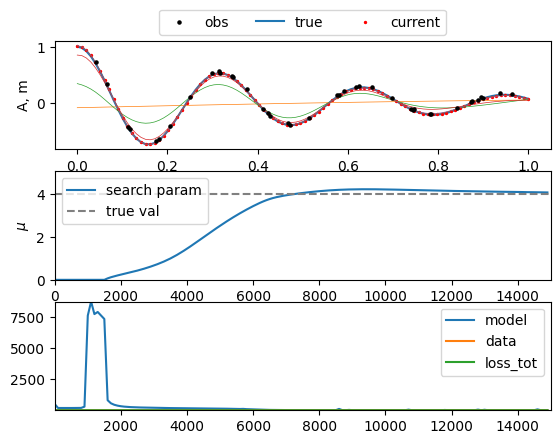

d= 2; w0= 20; true mu= 4


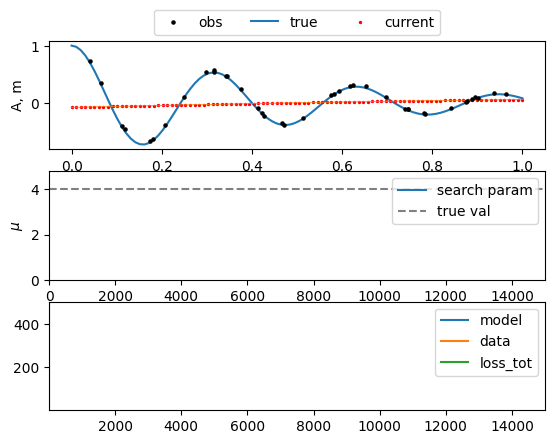

Solution: mu= 4.08


In [12]:
#%matplotlib notebook
#%matplotlib widget
torch.manual_seed(30)
fig, ax = plt.subplots(3)
hfig = display.display(fig, display_id=True);

# plot how mu changes with iterations
mu_vals,iter_vals = [0],[0]
mu_plot = ax[1].plot(iter_vals,mu_vals, label='search param')

# prepare plot for residuals
res1, res2, res_tot = [0.1],[0.1],[0.1]
plt_res1        = ax[2].plot(iter_vals, res1   , label='model')
plt_res2        = ax[2].plot(iter_vals, res2   , label='data')
plt_res_tot     = ax[2].plot(iter_vals, res_tot, label='loss_tot')
#ax[2].set_yscale('log')

m = 1
_,k = 2*m*d, w0**2*m
u0,v0 = 1,0
print(f'd= {d}; w0= {w0}; true mu= {2*m*d}')
# define corrupted observation data, plot it
times_obs = torch.rand(40)
u_obs = anal(d,w0,times_obs)
u_obs += + 0.04*torch.rand_like(u_obs)

plot_obs = ax[0].scatter(times_obs, u_obs,s= 5, zorder=3, color='k', label='obs')

times_obs = times_obs.view(-1,1).requires_grad_(True).to(device)
u_obs = u_obs.view(-1,1).to(device)

# plot analic, true solution
times_anal = torch.linspace(0,1,100)
u_anal = anal(d,w0,times_anal)
plot_anal = ax[0].plot(times_anal, u_anal, label='true')

# plot current output of a network
times_anal = times_anal.view(-1,1).to(device)
u_c_plot = pinn(times_anal).cpu().detach().squeeze()
u_current = ax[0].scatter(times_anal.cpu().detach().squeeze(), u_c_plot, s= 2, label='current',zorder=2, color='r')

mu = torch.nn.Parameter(torch.zeros(1).requires_grad_(True).to(device))

optimizer = torch.optim.Adam(list(pinn.parameters()) + [mu], lr = 1e-3)


ax[0].set_xlabel('t, s')
ax[0].set_ylabel('A, m');

ax[1].set_xlabel('iter')
ax[1].set_ylabel(r'$\mu$');

hfig.update(fig);

MAX_ITERS = 15000
ax[1].set_xlim(0        ,MAX_ITERS)
ax[1].set_ylim(0        ,2*m*d*1.2)
ax[2].set_xlim(0.0001   ,MAX_ITERS)

lambda1 = 1e-4

times_grid = torch.linspace(0,1,120).view(-1,1).requires_grad_(True).to(device)
ax[1].hlines(y=2*m*d,xmin=0,xmax=MAX_ITERS, colors='gray', ls='--',label='true val')
ax[2].legend()
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3)
ax[1].legend()

for i in range(MAX_ITERS):
    optimizer.zero_grad()

    # compute u(t) and its derivatives
    u_all = pinn(times_grid)
    dudt = torch.autograd.grad(u_all, times_grid, torch.ones_like(u_all), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, times_grid, torch.ones_like(dudt), create_graph=True)[0]

    # test fit to ODE
    loss_model_fit = torch.mean((d2udt2 + mu/m*dudt + k/m*u_all - 0)**2)

    # compute u(t) at obseverd data times
    u_model = pinn(times_obs)

    # test how it fits to data
    loss_data_fit = torch.mean((u_obs-u_model)**2)

    # combine losses. say at first third focus on data fit
    loss = loss_data_fit
    # after start fitting ODE
    if i > MAX_ITERS/10:    # might not be good for backprop.
        loss += lambda1*loss_model_fit
    
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        u_draw = pinn(times_anal).cpu().detach().squeeze()
        t_draw = times_anal.cpu().detach().squeeze()
        u_current.set_offsets(np.vstack((t_draw, u_draw)).T)
        mu_vals.append(mu.item())
        iter_vals.append(i)

        res1.append(loss_model_fit.cpu().detach().item())
        res2.append(loss_data_fit.cpu().detach().item())
        res_tot.append(loss.cpu().detach().item())
        res_all = res1 + res2 + res_tot
        mu_plot[0].set_data(iter_vals       , mu_vals)
        plt_res1[0].set_data(iter_vals      , res1)
        plt_res2[0].set_data(iter_vals      , res2)
        plt_res_tot[0].set_data(iter_vals   , res_tot)
        
        ax[1].set_ylim(min(mu_vals)*1.2 , max(max(mu_vals)*1.2, 2*m*d*1.2))
        ax[2].set_ylim(min(res_all)+0.001 , max(res_all))

        if i % 3000 == 0:
            ax[0].plot(t_draw, u_draw, label=f'iter:{i}', linewidth = 0.5)
            #plt.legend()
        hfig.update(fig);
        plt.pause(0.01);

plt.close()
print(f'Solution: mu= {mu.item():0.2f}')